# *Walmart Sales prediction*

This notebook try to solve the walmart Sales Prediction problem stated here 
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview

# Importing Libraries and Data files 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.preprocessing import StandardScaler #for scaling
import matplotlib.pyplot as plt # ploting
from sklearn.metrics import mean_absolute_error #calculate error 
from sklearn.model_selection import train_test_split #splitting the data
from sklearn.model_selection import KFold # splitting the data
from sklearn.neural_network import MLPRegressor
#from google.colab import drive
from sklearn.impute import SimpleImputer #dealing with nulls
import seaborn as sns #plotting the data
import datetime
from sklearn.metrics import make_scorer #scoring
from sklearn.model_selection import GridSearchCV #find best Model


#drive.mount('/content/drive')

In [2]:
#Load the Dataset

'''
features= pd.read_csv("/content/drive/My Drive/Colab Notebooks/features.csv")
stores=pd.read_csv("/content/drive/My Drive/Colab Notebooks/stores.csv")
test=pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")
train=pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")

'''

features= pd.read_csv("../OneDrive/features.csv")
stores=pd.read_csv("../OneDrive/stores.csv")
test=pd.read_csv("../OneDrive/test.csv")
train=pd.read_csv("../OneDrive/train.csv")


# Exploring the Data Set

In [3]:
#let's try to take a look over the dataset
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


After we took a look over the data, let's check if the data have nulls, and how clean is it 

---



In [6]:
#Check Nulls
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [7]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [8]:
test.isnull().sum()

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

In [9]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

# Cleaning the Data

In [6]:
#Dealing with Nulls, for CPI and unimployment we will take medians 
# and for markdowns we will replace nulls with zeros
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer = imputer.fit(features[['CPI']])
features['CPI'] = imputer.transform(features[['CPI']])
imputer = imputer.fit(features[['Unemployment']])
features['Unemployment'] = imputer.transform(features[['Unemployment']])
features=features.fillna(0)

now we will join the data togather to have a full look on the data set we have
then we will look if we need to deal with any of the columns

In [7]:
#df creation and joining
df=train
df=df.join(stores.set_index('Store'), on='Store')
df['store_date']=df['Store'].astype(str)+df['Date']
features['store_date']=features['Store'].astype(str)+features['Date']
features=features.drop(['Store','Date','IsHoliday'],axis=1)
df=df.merge(features,left_on='store_date',right_on='store_date')
df=df.rename(columns={"Type": "store_type", "Size": "store_size"})
df=df.rename(str.lower, axis='columns')

In [8]:
# data types
df.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
isholiday          bool
store_type       object
store_size        int64
store_date       object
temperature     float64
fuel_price      float64
markdown1       float64
markdown2       float64
markdown3       float64
markdown4       float64
markdown5       float64
cpi             float64
unemployment    float64
dtype: object

In [9]:
# creating an identifier
df['store_date_dep']=df['store_date']+df['dept'].astype(str)

In [10]:
#arranging columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,store_date_dep,store,dept,date,weekly_sales,isholiday,store_type,store_size,store_date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment
0,12010-02-051,1,1,2010-02-05,24924.50,False,A,151315,12010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,12010-02-052,1,2,2010-02-05,50605.27,False,A,151315,12010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
2,12010-02-053,1,3,2010-02-05,13740.12,False,A,151315,12010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
3,12010-02-054,1,4,2010-02-05,39954.04,False,A,151315,12010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
4,12010-02-055,1,5,2010-02-05,32229.38,False,A,151315,12010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106


In [11]:
# Dealing with categorical Columns

df['isholiday']=df['isholiday'].map({True:1,False:0})

In [12]:
df['store_type']=df['store_type'].map({'A':0,'B':1,'C':2})
#getting week number
df['date']=pd.to_datetime(df['date'])
df['week']=df['date'].dt.week

first we will try to see the realtion between the weekly sales with each of the features

In [13]:
#summrizeing the data
salesVSweek=pd.pivot_table(df, values='weekly_sales', index=['week'], aggfunc=np.mean)
#dropping unneeded columns
df=df.drop(['store_date_dep','date','store_date'],axis=1)

# Visualizing the data

In [14]:
def graphs (weekly_sales,data,column):
  '''
    input:  (weekly_sales,the column we want to graph vs weekly sales,column name)
    plot ....
    output: (the graph of selected columns vs weekly sales)
    '''
  plt.figure()
  plt.scatter(data , weekly_sales)
  plt.ylabel('weekly_sales')
  plt.xlabel(column)

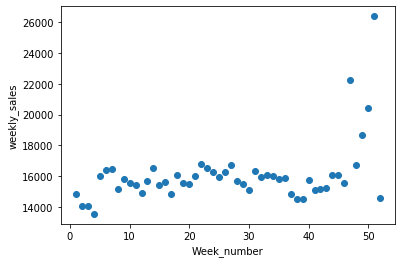

In [19]:
graphs(salesVSweek['weekly_sales'],salesVSweek.index,'Week_number')


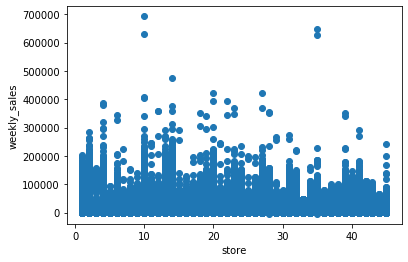

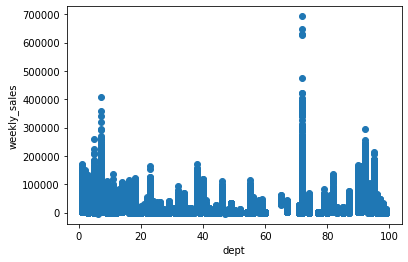

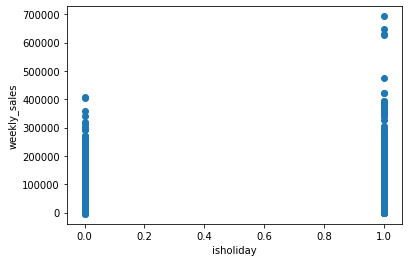

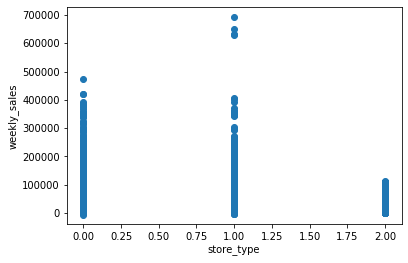

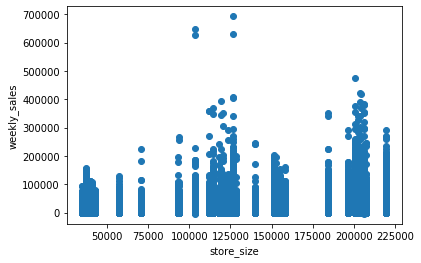

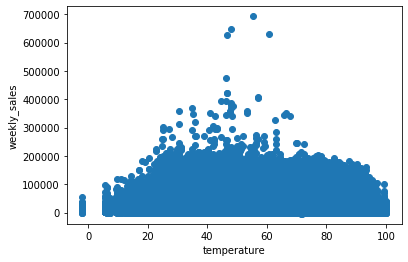

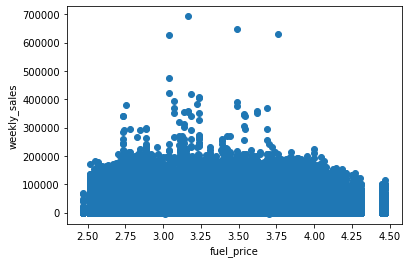

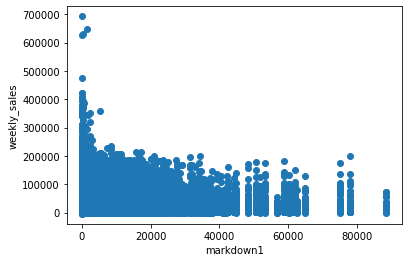

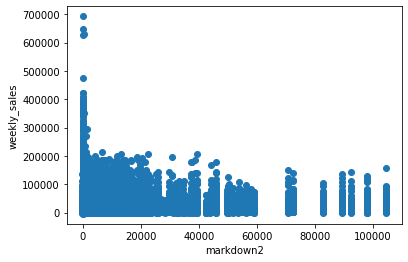

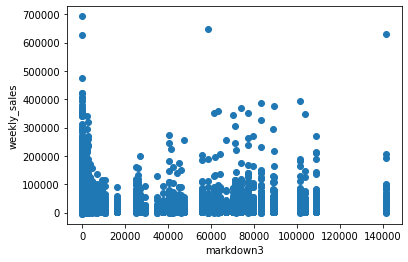

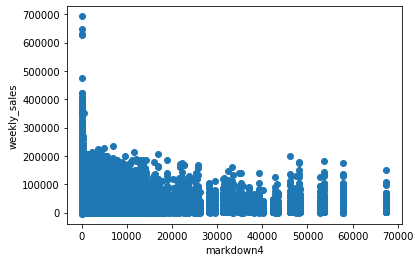

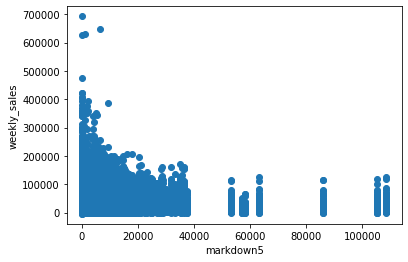

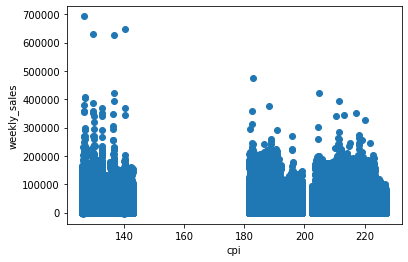

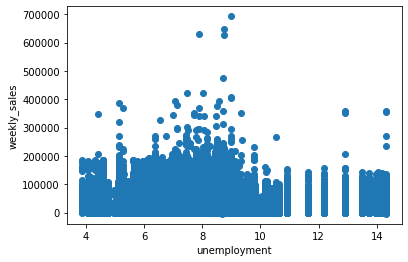

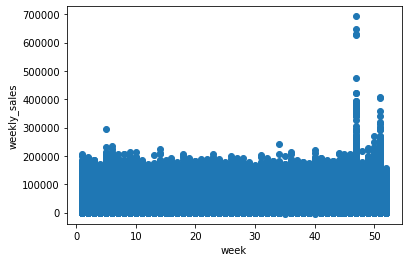

In [20]:
for column in df.columns.tolist():
    if column == 'weekly_sales':
        continue
    elif column == 'store_date_dep':
        continue
    
    else:
        graphs(df['weekly_sales'],df[column],column)

from the graphs above we see the clear relations of weekly sales with temperature, CPI, store type, and unemployment rate.

to go further and try to gather more insights from the data.we will try to draw graphs for all the columns againest each other to see the relations between the columns

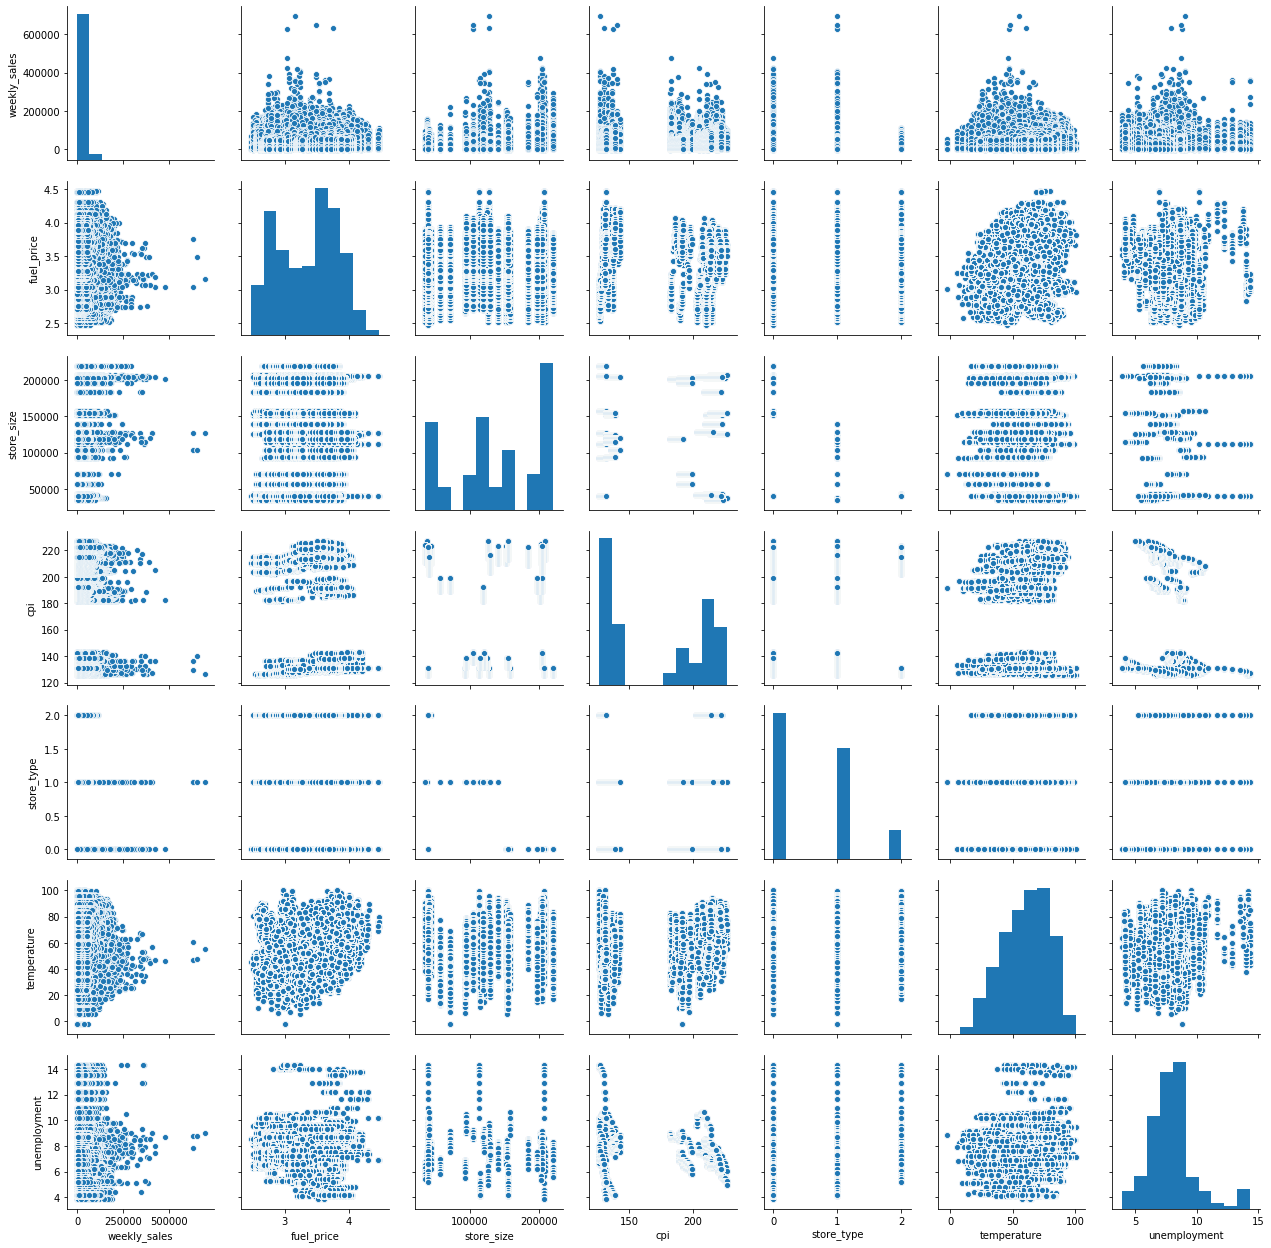

In [21]:
sns.pairplot(df, vars=['weekly_sales', 'fuel_price', 'store_size', 'cpi', 'store_type', 'temperature', 'unemployment'])

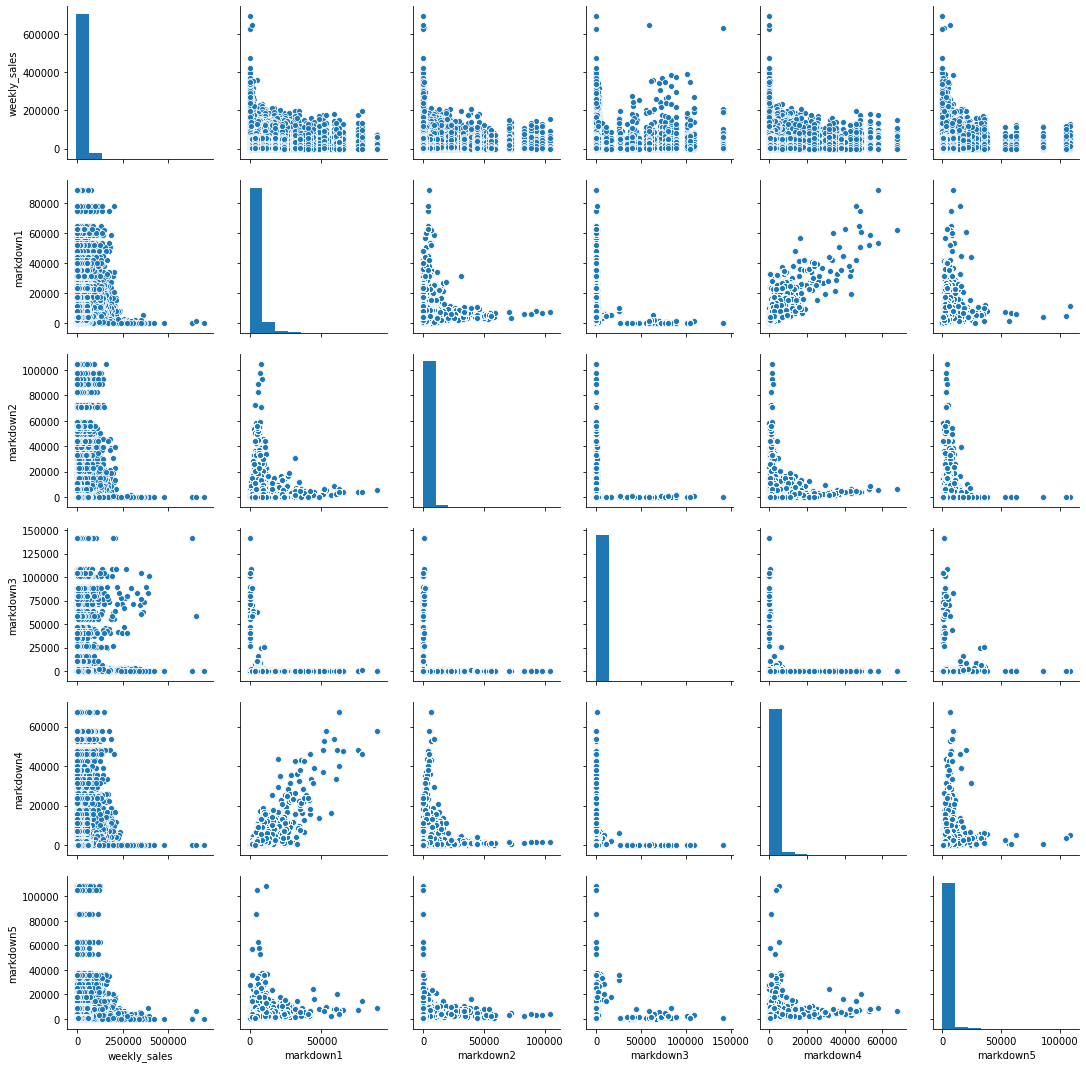

In [22]:
sns.pairplot(df, vars=['weekly_sales', 'markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5'])

It seems that weekly sales are affected by different reasons. So, people tend to buy more from Walmart during periods of moderate temperatures during holidays, when the prices are low, from large stores and particular types of stores.

# Preprosses the data for the Training models

In [15]:
#droping unneeded models
df=df.drop(['markdown2','markdown5','fuel_price'],axis=1)

In [16]:
#splitting features and values into training and testing
features_df=df.copy()
features_df=features_df.drop('weekly_sales',axis=1)
values_df=df['weekly_sales']

#scaling Data
scaler=StandardScaler()
scaler=scaler.fit(features_df)
features_df_scaled=scaler.transform(features_df)
features_df_scaled=pd.DataFrame(features_df_scaled, columns=features_df.columns)


In [17]:
features_df_scaled.head()

,store,dept,isholiday,store_type,store_size,temperature,markdown1,markdown3,markdown4,cpi,unemployment,week
0,-1.658199,-1.418742,-0.275106,-0.885307,0.239209,-0.963798,-0.427943,-0.084662,-0.278117,1.018774,0.078201,-1.471661
1,-1.658199,-1.385947,-0.275106,-0.885307,0.239209,-0.963798,-0.427943,-0.084662,-0.278117,1.018774,0.078201,-1.471661
2,-1.658199,-1.353151,-0.275106,-0.885307,0.239209,-0.963798,-0.427943,-0.084662,-0.278117,1.018774,0.078201,-1.471661
3,-1.658199,-1.320356,-0.275106,-0.885307,0.239209,-0.963798,-0.427943,-0.084662,-0.278117,1.018774,0.078201,-1.471661
4,-1.658199,-1.287560,-0.275106,-0.885307,0.239209,-0.963798,-0.427943,-0.084662,-0.278117,1.018774,0.078201,-1.471661


# setting the models

In [18]:
#import and initialize the Models

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import Nystroem

# Initialize the four models
clf_A = RandomForestRegressor(max_features='log2', verbose=1)
clf_B = KNeighborsRegressor()
clf_C =MLPRegressor()
clf_D= SGDRegressor()
clf=[clf_A,clf_B,clf_D] #clf_A,clf_B,clf_C
feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=300)


In [19]:
def train_predict(learner, X_train, X_test,y_train, y_test,weights,i): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    error_1=[]
    # Fit the learner to the training data 
    model=learner.fit(X_train, y_train)
    
   
    # Get the predictions on the test set(X_test),
    predictions_test = learner.predict(X_test)
 
    #calculate the error
    error=mean_absolute_error(y_test, predictions_test, sample_weight=weights)
    error=abs(error)
    error_total=+error
    i=+1
    print(i)
    return error, error_total

In [20]:
# define some factor needed for taining the model
best_error=9223372036854775807
weights=features_df['isholiday'].replace(1, 5).replace(0, 1)
scorer=make_scorer(mean_absolute_error)


In [21]:
def get_p(clf,clf_A,clf_B,clf_C,clf_D):
    '''input: 
        - model processed
        - expected models
    output: 
        -corrisponding paramters
        '''
    if clf == clf_A:
        parameters = {'n_estimators':[150,200,250]}
    elif clf== clf_B:
        parameters = {'n_neighbors':[5,10,20]}
    elif clf== clf_C:
        parameters = {'hidden_layer_sizes':[100,200]}
    elif clf== clf_D:
        parameters = {'max_iter':[500,1000]}
    return parameters

# K-Fold

In [22]:
kf = KFold(n_splits=5)
error_1=[]
i=0
from sklearn.kernel_approximation import Nystroem
for model in clf:

    if model == clf_D:
        feature_map_nystroem=feature_map_nystroem.fit(features_df_scaled)
        
    parameters=get_p(model,clf_A,clf_B,clf_C,clf_D)
    print(parameters)
    grid_obj = GridSearchCV(model, parameters, scoring=scorer,n_jobs=-1)
    
    grid_fit = grid_obj.fit(features_df_scaled, values_df)
    
    model = grid_fit.best_estimator_

    for train_index, test_index in kf.split(df):
        X_train, X_test, y_train, y_test = features_df_scaled.loc[train_index],features_df_scaled.loc[test_index],values_df.loc[train_index],values_df.loc[test_index]
        
        weights=X_test['isholiday'].replace(1, 5).replace(0, 1)
        
        if model == clf_D:
            X_train = feature_map_nystroem.transform(X_train)
            X_test = feature_map_nystroem.transform(X_test)
        
        error, error_total=train_predict(model,X_train, X_test, y_train, y_test,weights,i)
        
        error_1.append(error)
        error_total= error_total/5
        if error< best_error:
            best_model=model
            best_error= error

{'n_estimators': [150, 200, 250]}


C:\Users\MediaServer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.0s finished


0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished


0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished


0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.6s finished


0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
C:\Users\MediaServer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0
{'n_neighbors': [5, 10, 20]}
0
0
0
0
0
{'max_iter': [500, 1000]}


C:\Users\MediaServer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0
0
0
0
0


In [23]:
print(best_error)

81483.30724945539


In [35]:
error_1

[491844.10231882386,
 494414.92735113663,
 725521.3729620781,
 206196.8825584427,
 122384.61810459722,
 1102174.2971825833,
 1062402.1181000173,
 2401913.3012374085,
 496901.0020007349,
 357524.0957737619,
 524579.9409539211,
 918394.2746033893,
 1787753.159766897,
 118360.15404787668,
 81483.30724945539]

now once we got the best model of the four we will try to make our preduction for the sales in the future
first step we will start by preparing the testing data

In [24]:
best_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

# Testing

In [27]:
#preparing testing Data to be loaded in the model
features= pd.read_csv("../OneDrive/features.csv")
features['CPI'] = imputer.transform(features[['CPI']])
features['Unemployment'] = imputer.transform(features[['Unemployment']])
features=features.fillna(0)
features['store_date']=features['Store'].astype(str)+features['Date']
features=features.drop(['Store','Date','IsHoliday'],axis=1)

test_data=test
test_data=test_data.join(stores.set_index('Store'), on='Store')
test_data['store_date']=test_data['Store'].astype(str)+test_data['Date']
test_data=test_data.merge(features,left_on='store_date',right_on='store_date')
test_data=test_data.rename(columns={"Type": "store_type", "Size": "store_size"})
test_data=test_data.rename(str.lower, axis='columns')
test_data['store_date_dept']=test_data['store'].astype(str)+test_data['date']+test_data['dept'].astype(str)
cols = test_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
test_data = test_data[cols]
test_data['isholiday']=test_data['isholiday'].map({True:1,False:0})
test_data['store_type']=test_data['store_type'].map({'A':0,'B':1,'C':2})
test_data['date']=pd.to_datetime(test_data['date'])
test_data['week']=test_data['date'].dt.week
dates=pd.DataFrame()
dates['date']=test_data['date']
test_data=test_data.drop(['store_date_dept','date','store_date'],axis=1)
test_data=test_data.drop(['markdown2','markdown5','fuel_price'],axis=1)
test_data_scaled=scaler.transform(test_data)
test_data_scaled=pd.DataFrame(test_data_scaled, columns=features_df.columns)


In [1]:
# predicting the data
if best_model ==clf_D:
    test_data=feature_map_nystroem.transform(test_data_scaled)

weekly_sales=best_model.predict(test_data_scaled)


NameError: name 'best_model' is not defined

In [32]:
test['weekly_sales']=weekly_sales

In [33]:
test.head()

,Store,Dept,Date,IsHoliday,weekly_sales
0,1,1,2012-11-02,False,15487.318070
1,1,1,2012-11-09,False,15578.827716
2,1,1,2012-11-16,False,15670.337361
3,1,1,2012-11-23,True,15761.847007
4,1,1,2012-11-30,False,15853.356652


In [34]:
#exporting the data
test.to_csv(path_or_buf='../OneDrive/fea.csv')